## GIS 5572 Lab 2

This notebook is part of Lab 2, and is the ingestion and QA for the census data to be used with our final project.

## 2022 ACS 5 year data about race
Citation:
Steven Manson, Jonathan Schroeder, David Van Riper, Katherine Knowles, Tracy Kugler, Finn Roberts, and Steven Ruggles. IPUMS National Historical Geographic Information System: Version 18.0 [dataset]. Minneapolis, MN: IPUMS. 2023. http://doi.org/10.18128/D050.V18.0


The following notebook is the acquisition, processing, cleaning and prepartion of the data from the 2022 ACS 5 year (2018-2022) estimates of population of racial groups in Hennepin County. Oddly, there was no category for Hispanic.

I worked with the NHGIS API for hours without success. Thus, this notebook works with data downloaded from NHGIS that took me about 3 minutes to acquire. 

In [1]:
# import the modules I need
import zipfile
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona
import csv

## Open CSV with Census Data

In [4]:
# Only do this the first time you add the data from a Zip file. You don't need to run it again
# unzip the first set of CSVs
! unzip nhgis0046_csv.zip

Archive:  nhgis0046_csv.zip
  inflating: nhgis0046_csv/nhgis0046_ds262_20225_blck_grp_codebook.txt  
  inflating: nhgis0046_csv/nhgis0046_ds262_20225_blck_grp.csv  


In [4]:
# read the CSV file and check with .head

data = gpd.read_file("nhgis0046_csv/nhgis0046_ds262_20225_blck_grp.csv")
data.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,AQNGM010,AQPZM001,AQPZM002,AQPZM003,AQPZM004,AQPZM005,AQPZM006,AQPZM007,AQPZM008,geometry
0,G27000107701001,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,5,93,25,19,15,18,27,11,82,None
1,G27000107701002,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,23,96,15,64,22,10,42,21,81,None
2,G27000107701003,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,5,93,7,37,11,28,36,30,64,None
3,G27000107702001,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,21,100,8,43,10,36,54,12,79,None
4,G27000107702002,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,14,108,20,19,11,10,17,59,80,None


In [3]:
# see what columns are in the file.
# See the Codebook in order to pull only the data needed
data.columns

Index(['GISJOIN', 'YEAR', 'STUSAB', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA',
       'COUNTY', 'COUNTYA', 'COUSUBA', 'PLACEA', 'TRACTA', 'BLKGRPA',
       'CONCITA', 'AIANHHA', 'RES_ONLYA', 'TRUSTA', 'AIHHTLI', 'AITSA',
       'ANRCA', 'CBSAA', 'CSAA', 'METDIVA', 'NECTAA', 'CNECTAA', 'NECTADIVA',
       'UAA', 'CDCURRA', 'SLDUA', 'SLDLA', 'ZCTA5A', 'SUBMCDA', 'SDELMA',
       'SDSECA', 'SDUNIA', 'PCI', 'PUMAA', 'GEO_ID', 'BTTRA', 'BTBGA',
       'TL_GEO_ID', 'NAME_E', 'AQNGE001', 'AQNGE002', 'AQNGE003', 'AQNGE004',
       'AQNGE005', 'AQNGE006', 'AQNGE007', 'AQNGE008', 'AQNGE009', 'AQNGE010',
       'AQPZE001', 'AQPZE002', 'AQPZE003', 'AQPZE004', 'AQPZE005', 'AQPZE006',
       'AQPZE007', 'AQPZE008', 'NAME_M', 'AQNGM001', 'AQNGM002', 'AQNGM003',
       'AQNGM004', 'AQNGM005', 'AQNGM006', 'AQNGM007', 'AQNGM008', 'AQNGM009',
       'AQNGM010', 'AQPZM001', 'AQPZM002', 'AQPZM003', 'AQPZM004', 'AQPZM005',
       'AQPZM006', 'AQPZM007', 'AQPZM008', 'geometry'],
      dtype='object')

In [21]:
data.count()

GISJOIN      4706
YEAR         4706
STUSAB       4706
REGIONA      4706
DIVISIONA    4706
             ... 
AQPZM005     4706
AQPZM006     4706
AQPZM007     4706
AQPZM008     4706
geometry        0
Length: 80, dtype: int64

In [5]:
# Clean data to only select Hennepin County data
mndata = data[(data.STUSAB == "MN")]
mndata.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,AQNGM010,AQPZM001,AQPZM002,AQPZM003,AQPZM004,AQPZM005,AQPZM006,AQPZM007,AQPZM008,geometry
0,G27000107701001,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,5,93,25,19,15,18,27,11,82,None
1,G27000107701002,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,23,96,15,64,22,10,42,21,81,None
2,G27000107701003,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,5,93,7,37,11,28,36,30,64,None
3,G27000107702001,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,21,100,8,43,10,36,54,12,79,None
4,G27000107702002,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,14,108,20,19,11,10,17,59,80,None


In [5]:
# Drop the "geometry" column which is all None because you can't join with the shp file if they both have geometry columns
mndata = mndata.drop(columns=['geometry'])

In [6]:
# look at the data to make sure the geometry column is gone
mndata.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,AQNGM009,AQNGM010,AQPZM001,AQPZM002,AQPZM003,AQPZM004,AQPZM005,AQPZM006,AQPZM007,AQPZM008
0,G27000107701001,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,5,5,93,25,19,15,18,27,11,82
1,G27000107701002,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,5,23,96,15,64,22,10,42,21,81
2,G27000107701003,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,6,5,93,7,37,11,28,36,30,64
3,G27000107702001,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,7,21,100,8,43,10,36,54,12,79
4,G27000107702002,2018-2022,MN,,,Minnesota,27,Aitkin County,001,,...,9,14,108,20,19,11,10,17,59,80


In [7]:
# select only the Hennepin County data
mndata = mndata[(mndata.COUNTYA == "053")]
mndata.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,AQNGM009,AQNGM010,AQPZM001,AQPZM002,AQPZM003,AQPZM004,AQPZM005,AQPZM006,AQPZM007,AQPZM008
1294,G27005300001011,2018-2022,MN,,,Minnesota,27,Hennepin County,053,,...,9,99,230,52,175,9,38,24,142,152
1295,G27005300001012,2018-2022,MN,,,Minnesota,27,Hennepin County,053,,...,9,9,222,13,66,13,9,45,9,223
1296,G27005300001013,2018-2022,MN,,,Minnesota,27,Hennepin County,053,,...,27,21,178,24,62,32,41,92,9,183
1297,G27005300001014,2018-2022,MN,,,Minnesota,27,Hennepin County,053,,...,305,9,551,27,34,12,9,105,404,435
1298,G27005300001021,2018-2022,MN,,,Minnesota,27,Hennepin County,053,,...,9,15,571,77,256,15,259,68,41,438


In [8]:
mndata.count()

GISJOIN      1098
YEAR         1098
STUSAB       1098
REGIONA      1098
DIVISIONA    1098
             ... 
AQPZM004     1098
AQPZM005     1098
AQPZM006     1098
AQPZM007     1098
AQPZM008     1098
Length: 79, dtype: int64

In [9]:
mndata.rename(columns={'AQNGM001': 'Total', 'AQNGM002': 'White', 'AQNGM003': 'Black', 'AQNGM004': 'Indigenous', 'AQNGM005': 'Asian', 'AQNGM008': 'Two or More Races'}, inplace=True)


In [16]:
mndata.columns

Index(['GISJOIN', 'YEAR', 'STUSAB', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA',
       'COUNTY', 'COUNTYA', 'COUSUBA', 'PLACEA', 'TRACTA', 'BLKGRPA',
       'CONCITA', 'AIANHHA', 'RES_ONLYA', 'TRUSTA', 'AIHHTLI', 'AITSA',
       'ANRCA', 'CBSAA', 'CSAA', 'METDIVA', 'NECTAA', 'CNECTAA', 'NECTADIVA',
       'UAA', 'CDCURRA', 'SLDUA', 'SLDLA', 'ZCTA5A', 'SUBMCDA', 'SDELMA',
       'SDSECA', 'SDUNIA', 'PCI', 'PUMAA', 'GEO_ID', 'BTTRA', 'BTBGA',
       'TL_GEO_ID', 'NAME_E', 'AQNGE001', 'AQNGE002', 'AQNGE003', 'AQNGE004',
       'AQNGE005', 'AQNGE006', 'AQNGE007', 'AQNGE008', 'AQNGE009', 'AQNGE010',
       'AQPZE001', 'AQPZE002', 'AQPZE003', 'AQPZE004', 'AQPZE005', 'AQPZE006',
       'AQPZE007', 'AQPZE008', 'NAME_M', 'Total', 'White', 'Black',
       'Indigenous', 'Asian', 'AQNGM006', 'AQNGM007', 'Two or More Races',
       'AQNGM009', 'AQNGM010', 'AQPZM001', 'AQPZM002', 'AQPZM003', 'AQPZM004',
       'AQPZM005', 'AQPZM006', 'AQPZM007', 'AQPZM008'],
      dtype='object')

## Open Shape File

In [10]:
# Only do this the first time you add the data from a Zip file. You don't need to run it again
# unzip the shape files
! unzip nhgis0046_shape.zip

Archive:  nhgis0046_shape.zip
  inflating: nhgis0046_shape/nhgis0046_shapefile_tl2022_270_blck_grp_2022.zip  


In [11]:
# Only do this the first time you add the data from a Zip file. You don't need to run it again
# Unzip the next level of shape files
! unzip nhgis0046_shape/nhgis0046_shapefile_tl2022_270_blck_grp_2022.zip 

Archive:  nhgis0046_shape/nhgis0046_shapefile_tl2022_270_blck_grp_2022.zip
  inflating: MN_blck_grp_2022.sbn    
  inflating: MN_blck_grp_2022.dbf    
  inflating: MN_blck_grp_2022.sbx    
  inflating: MN_blck_grp_2022.GISJOIN.atx  
  inflating: MN_blck_grp_2022.cpg    
  inflating: MN_blck_grp_2022.prj    
  inflating: MN_blck_grp_2022.shp    
  inflating: MN_blck_grp_2022.shx    
  inflating: MN_blck_grp_2022.shp.xml  


In [10]:
# function to read the Shape file

counties = gpd.read_file("MN_blck_grp_2022.shp")

counties.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,ORIG_FID,geometry
0,G27000107701001,27,001,770100,1,270017701001,Block Group 1,G5030,S,707672985.0,40074485.0,+46.8763449,-093.2082035,166074.595393,7.477475e+08,143860,"POLYGON ((225007.066 1054492.139, 225015.987 1..."
1,G27000107701002,27,001,770100,2,270017701002,Block Group 2,G5030,S,219484633.0,16903574.0,+46.6721228,-093.4348000,73033.888039,2.363882e+08,143861,"POLYGON ((206761.799 1033184.671, 206752.983 1..."
2,G27000107701003,27,001,770100,3,270017701003,Block Group 3,G5030,S,259562397.0,4769466.0,+46.5858078,-093.5884389,93486.178211,2.643319e+08,143857,"POLYGON ((186453.125 1028062.072, 186441.166 1..."
3,G27000107702001,27,001,770200,1,270017702001,Block Group 1,G5030,S,890324568.0,14871127.0,+46.9181539,-093.5478041,185797.062015,9.051957e+08,143859,"POLYGON ((196173.898 1034106.119, 196171.474 1..."
4,G27000107702002,27,001,770200,2,270017702002,Block Group 2,G5030,S,286057575.0,9284768.0,+46.6963525,-093.6297396,114136.059036,2.953424e+08,143863,"POLYGON ((196173.898 1034106.119, 196174.209 1..."


In [12]:
# Select only Hennepin County
hennepin_geo = counties[(counties.COUNTYFP == "053")]
hennepin_geo.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,ORIG_FID,geometry
1293,G27005300001011,27,053,000101,1,270530001011,Block Group 1,G5030,S,441169.0,0.0,+45.0487444,-093.3038323,3496.840503,441168.385173,146347,"POLYGON ((212501.298 846841.195, 212479.437 84..."
1294,G27005300001012,27,053,000101,2,270530001012,Block Group 2,G5030,S,287225.0,0.0,+45.0492556,-093.3148316,2289.570676,287225.232082,146348,"POLYGON ((211701.950 847427.383, 211687.654 84..."
1295,G27005300001013,27,053,000101,3,270530001013,Block Group 3,G5030,S,954995.0,0.0,+45.0427482,-093.3094867,4974.206433,954995.718518,146349,"POLYGON ((212400.705 846837.891, 212402.357 84..."
1296,G27005300001014,27,053,000101,4,270530001014,Block Group 4,G5030,S,318148.0,0.0,+45.0458183,-093.3072289,2652.063259,318147.586811,147513,"POLYGON ((211701.950 847427.383, 211809.992 84..."
1297,G27005300001021,27,053,000102,1,270530001021,Block Group 1,G5030,S,803107.0,96793.0,+45.0380345,-093.2866755,4335.461465,899903.000592,146350,"POLYGON ((213948.506 846843.071, 213858.657 84..."


<Axes: >

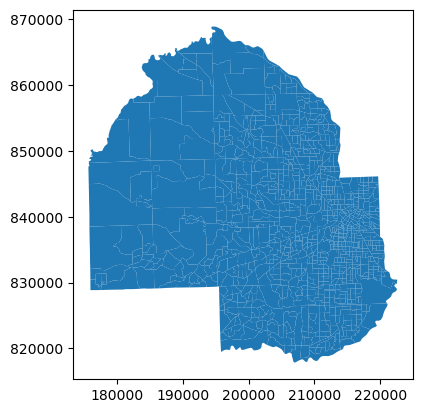

In [13]:
# QA Test: does this create a map??
hennepin_geo.plot()

## Join Data
Join the Block Group data to the Demographic Data

In [17]:
# join using the "merge" function
henn_data = hennepin_geo.merge(mndata, on='GISJOIN')

In [18]:
# QA: Did this work?
henn_data.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,AQNGM009,AQNGM010,AQPZM001,AQPZM002,AQPZM003,AQPZM004,AQPZM005,AQPZM006,AQPZM007,AQPZM008
0,G27005300001011,27,053,000101,1,270530001011,Block Group 1,G5030,S,441169.0,...,9,99,230,52,175,9,38,24,142,152
1,G27005300001012,27,053,000101,2,270530001012,Block Group 2,G5030,S,287225.0,...,9,9,222,13,66,13,9,45,9,223
2,G27005300001013,27,053,000101,3,270530001013,Block Group 3,G5030,S,954995.0,...,27,21,178,24,62,32,41,92,9,183
3,G27005300001014,27,053,000101,4,270530001014,Block Group 4,G5030,S,318148.0,...,305,9,551,27,34,12,9,105,404,435
4,G27005300001021,27,053,000102,1,270530001021,Block Group 1,G5030,S,803107.0,...,9,15,571,77,256,15,259,68,41,438


In [22]:
print(henn_data['Total'].dtypes)

object


In [26]:
# Change the dtype from "object" to "numeric"

columns_to_convert = ['Total', 'White', 'Black','Indigenous', 'Asian']
henn_data[columns_to_convert] = henn_data[columns_to_convert].apply(pd.to_numeric)


In [30]:
# Create new percentage columns by dividing each population column by 'Total Population'
for col in columns_to_convert:
    henn_data[col + ' Percentage'] = (henn_data[col] / henn_data['Total'] * 100).round(2)

# Display the DataFrame with the new columns
henn_data.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,AQPZM008,Black_percent,White_percent,Indigenous_percent,Asian_percent,Total Percentage,White Percentage,Black Percentage,Indigenous Percentage,Asian Percentage
0,G27005300001011,27,053,000101,1,270530001011,Block Group 1,G5030,S,441169.0,...,152,51.764706,36.470588,3.529412,80.784314,100.0,36.47,51.76,3.53,80.78
1,G27005300001012,27,053,000101,2,270530001012,Block Group 2,G5030,S,287225.0,...,223,54.585153,60.262009,19.650655,3.930131,100.0,60.26,54.59,19.65,3.93
2,G27005300001013,27,053,000101,3,270530001013,Block Group 3,G5030,S,954995.0,...,183,56.741573,82.022472,15.730337,55.056180,100.0,82.02,56.74,15.73,55.06
3,G27005300001014,27,053,000101,4,270530001014,Block Group 4,G5030,S,318148.0,...,435,8.529946,13.430127,5.807623,84.029038,100.0,13.43,8.53,5.81,84.03
4,G27005300001021,27,053,000102,1,270530001021,Block Group 1,G5030,S,803107.0,...,438,85.989492,16.987741,7.880911,55.866900,100.0,16.99,85.99,7.88,55.87


## Test the data quality
Testing the data by visualizing it

In [1]:
# Let's test
henn_data.plot("Black Percentage", legend=True)

# Based on my knowledge of Hennepin County, this map appears to be reasonable. 

NameError: name 'henn_data' is not defined

<Axes: >

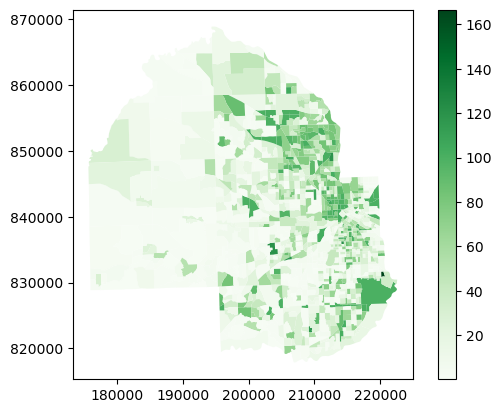

In [33]:
henn_data.plot("Black Percentage", cmap = "Greens", legend=True)

<Axes: >

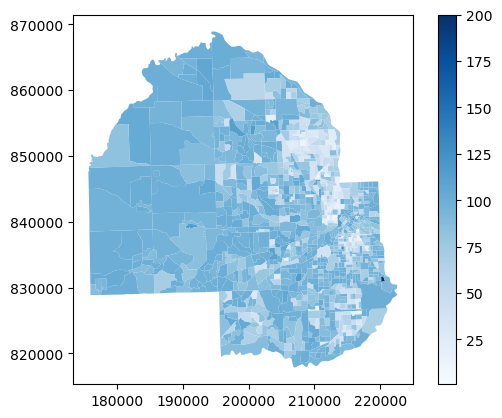

In [34]:
henn_data.plot("White Percentage", cmap = "Blues", legend=True)

<Axes: >

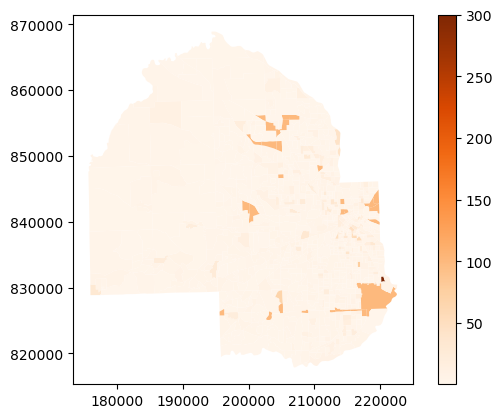

In [35]:
henn_data.plot("Indigenous Percentage", cmap = "Oranges", legend=True)

<Axes: >

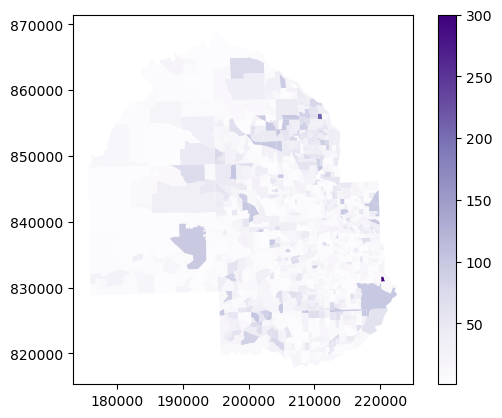

In [36]:
henn_data.plot("Asian Percentage", cmap = "Purples", legend=True)

## Save to CSV

In [38]:
# identify the columns to transfer
# Display all column names
print("Column names:", henn_data.columns)

Column names: Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       ...
       'AQPZM008', 'Black_percent', 'White_percent', 'Indigenous_percent',
       'Asian_percent', 'Total Percentage', 'White Percentage',
       'Black Percentage', 'Indigenous Percentage', 'Asian Percentage'],
      dtype='object', length=104)


In [39]:
print("Column names:", list(henn_data.columns))

Column names: ['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng', 'Shape_Area', 'ORIG_FID', 'geometry', 'YEAR', 'STUSAB', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA', 'COUSUBA', 'PLACEA', 'TRACTA', 'BLKGRPA', 'CONCITA', 'AIANHHA', 'RES_ONLYA', 'TRUSTA', 'AIHHTLI', 'AITSA', 'ANRCA', 'CBSAA', 'CSAA', 'METDIVA', 'NECTAA', 'CNECTAA', 'NECTADIVA', 'UAA', 'CDCURRA', 'SLDUA', 'SLDLA', 'ZCTA5A', 'SUBMCDA', 'SDELMA', 'SDSECA', 'SDUNIA', 'PCI', 'PUMAA', 'GEO_ID', 'BTTRA', 'BTBGA', 'TL_GEO_ID', 'NAME_E', 'AQNGE001', 'AQNGE002', 'AQNGE003', 'AQNGE004', 'AQNGE005', 'AQNGE006', 'AQNGE007', 'AQNGE008', 'AQNGE009', 'AQNGE010', 'AQPZE001', 'AQPZE002', 'AQPZE003', 'AQPZE004', 'AQPZE005', 'AQPZE006', 'AQPZE007', 'AQPZE008', 'NAME_M', 'Total', 'White', 'Black', 'Indigenous', 'Asian', 'AQNGM006', 'AQNGM007', 'Two or More Races', 'AQNGM009', 'AQNGM010', 'AQPZM001', 'AQPZM002', 'AQPZM00

In [40]:
## Save only a subset of the columns to the new csv

subset_df = henn_data[['Shape_Leng', 'Shape_Area', 'ORIG_FID', 'geometry', 'YEAR', 'COUNTY',  'Total Percentage', 'White Percentage', 'Black Percentage', 'Indigenous Percentage', 'Asian Percentage']]  # Selecting only some columns
subset_df.to_csv('hennepin_data.csv', index=False)  # Save subset DataFrame as CSV

print("Subset DataFrame saved as CSV successfully.")

Subset DataFrame saved as CSV successfully.


## Save Dataframe to Postgres Database

The goal of this is to save this data to a local geodatabase and in the remote PostGIS database. I did save it as a CSV, but ideally, I could save the dataframe right to the database. 

I have documenation about how to make this work, however, as of yet, I have not been successful.

Documentation (thanks, Luke!):

** https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html

** https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_postgis.html

In [2]:
>>> from sqlalchemy import create_engine
>>> engine = create_engine('sqlite://', echo=False)